In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
import networkx as nx
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import subprocess
import pandas as pd

from nosh.sim import NoshGraphSimulation

In [95]:
# Initialize bipartite graph
initial_buyers_kwargs = [
    {'transact_probability': 0.5}, 
    {'transact_probability': 0.5}, 
    {'transact_probability': 0.5}, 
]
initial_sellers_kwargs = [
    {'transact_probability': 1.0}, 
    {'transact_probability': 1.0}, 
    {'transact_probability': 1.0}, 
]
new_buyer_kwargs = {'transact_probability': 0.5}
new_seller_kwargs = {'transact_probability': 1.0}
simulation = NoshGraphSimulation(
    initial_buyers_kwargs, 
    initial_sellers_kwargs,
    new_buyer_kwargs,
    new_seller_kwargs,
)

# Set the probability vector for adding, deleting, or maintaining the graph in terms of number of nodes
add_delete_maintain_probs = [0.4, 0.3, 0.3]

# Run the simulation
num_time_steps = 100
graph_evolution_metrics = simulation.run(num_time_steps, add_delete_maintain_probs)
seller2weight_list = []
total_graph_weight_list = []
total_supply_vec = []
seller2ec_list = []
total_graph_value_list = []
for metric in graph_evolution_metrics:
    seller2weight = metric['seller2weight']
    
    seller2weight_list.append(seller2weight)
    seller2ec_list.append(metric['eigenvector_centrality'])
    total_supply_vec.append(metric['total_supply'])
    
    total_graph_weight = 0
    for seller, buyers in seller2weight.items():
        for b, w in buyers.items():
            total_graph_weight += w
    total_graph_weight_list.append(total_graph_weight)

    total_value = 0
    for s, v in metric['seller2value'].items():
        total_value += v
    total_graph_value_list.append(total_value)

{<nosh.buyer_agent.BuyerAgent object at 0x7fdfc1752590>: 0.408248290463863, <nosh.buyer_agent.BuyerAgent object at 0x7fdfc17525c0>: 0.408248290463863, <nosh.buyer_agent.BuyerAgent object at 0x7fdfc1752530>: 0.408248290463863, <nosh.producer_agent.SellerAgent object at 0x7fdfc17524d0>: 0.408248290463863, <nosh.producer_agent.SellerAgent object at 0x7fdfc1752470>: 0.408248290463863, <nosh.producer_agent.SellerAgent object at 0x7fdfc1750c10>: 0.408248290463863}
{<nosh.buyer_agent.BuyerAgent object at 0x7fdfc1752590>: 0.7071067811833319, <nosh.buyer_agent.BuyerAgent object at 0x7fdfc17525c0>: 1.3486991523424757e-06, <nosh.buyer_agent.BuyerAgent object at 0x7fdfc1752530>: 1.3486991523424757e-06, <nosh.producer_agent.SellerAgent object at 0x7fdfc17524d0>: 0.7071067811833319, <nosh.producer_agent.SellerAgent object at 0x7fdfc1752470>: 1.3486991523424757e-06, <nosh.producer_agent.SellerAgent object at 0x7fdfc1750c10>: 1.3486991523424757e-06, <nosh.buyer_agent.BuyerAgent object at 0x7fdfc1750a9

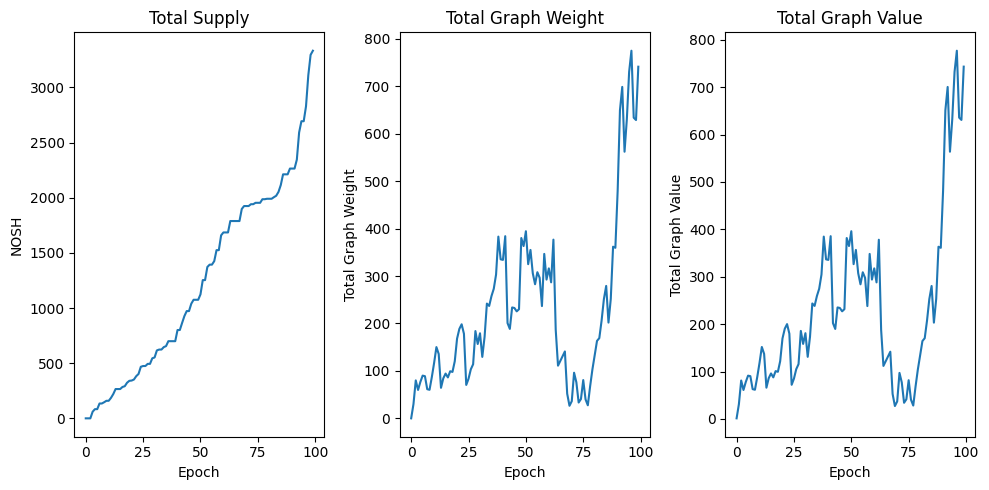

In [93]:
# TODO: debug why EC is not going into total value

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

ax[0].plot(total_supply_vec)
ax[0].set_title('Total Supply')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('NOSH')

ax[1].plot(total_graph_weight_list)
ax[1].set_title('Total Graph Weight')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Total Graph Weight')

ax[2].plot(total_graph_value_list)
ax[2].set_title('Total Graph Value')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Total Graph Value')

plt.tight_layout()